# Imports and Common Functions

In [39]:
import requests
import json
import pandas as pd
import numpy as np
import datetime

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Loading in data from Parse

In [2]:
# URL and header for Parse
base_url = 'https://dtr-les.herokuapp.com/parse/classes/'
header = {'X-Parse-Application-Id': 'PkngqKtJygU9WiQ1GXM9eC0a17tKmioKKmpWftYr'}
data = {'limit': '10000'}

# hotspots
resp = requests.get(base_url + 'hotspot', headers=header, data=data)
hotspots = pd.DataFrame(resp.json()['results'])

hotspot_string_cols = ['objectId', 'vendorId', 'archiver', 'locationCommonName', \
                       'tag', 'submissionMethod', 'beaconId']
hotspots['createdAt'] = (pd.to_datetime(hotspots['createdAt']).astype(np.int64) // 10**9)
hotspots['updatedAt'] = (pd.to_datetime(hotspots['updatedAt']).astype(np.int64) // 10**9)
hotspots[hotspot_string_cols] = hotspots[hotspot_string_cols].astype(str)

# sent notifications
resp = requests.get(base_url + 'notificationSent', headers=header, data=data)
notification_sent = pd.DataFrame(resp.json()['results'])

notification_sent_string_cols = ['objectId', 'vendorId', 'hotspotId', 'notificationString']
notification_sent['createdAt'] = (pd.to_datetime(notification_sent['createdAt']).astype(np.int64) // 10**9)
notification_sent['updatedAt'] = (pd.to_datetime(notification_sent['updatedAt']).astype(np.int64) // 10**9)
notification_sent[notification_sent_string_cols] = notification_sent[notification_sent_string_cols].astype(str)

# notification responses
resp = requests.get(base_url + 'pingResponse', headers=header, data=data)
notification_responses = pd.DataFrame(resp.json()['results'])

notification_responses_string_cols = ['objectId', 'hotspotId', 'vendorId', 'question', 'response', 'tag']
notification_responses['createdAt'] = (pd.to_datetime(notification_responses['createdAt']).astype(np.int64) // 10**9)
notification_responses['updatedAt'] = (pd.to_datetime(notification_responses['updatedAt']).astype(np.int64) // 10**9)
notification_responses[notification_responses_string_cols] = \
    notification_responses[notification_responses_string_cols].astype(str)

# users
resp = requests.get(base_url + 'user', headers=header, data=data)
users = pd.DataFrame(resp.json()['results'])

user_string_cols = ['objectId', 'firstName', 'lastName', 'vendorId', \
                    'firstPreference', 'secondPreference', 'thirdPreference', 'fourthPreference']
users['createdAt'] = (pd.to_datetime(users['createdAt']).astype(np.int64) // 10**9)
users['updatedAt'] = (pd.to_datetime(users['updatedAt']).astype(np.int64) // 10**9)
users[user_string_cols] = users[user_string_cols].astype(str)

# pretracking debug (to see app terminations) 
resp = requests.get(base_url + 'pretracking_debug', headers=header, data=data)
debug = pd.DataFrame(resp.json()['results'])

debug_string_cols = ['objectId', 'vendor_id', 'console_string']
debug['createdAt'] = (pd.to_datetime(debug['createdAt']).astype(np.int64) // 10**9)
debug['updatedAt'] = (pd.to_datetime(debug['updatedAt']).astype(np.int64) // 10**9)
debug[debug_string_cols] = debug[debug_string_cols].astype(str)

# Clean Data

In [3]:
# filter data for timestamps between CST start and end time
start_time = 1494306000 # 05-09-2017 00:00:00
end_time   = 1495342800 # 05-21-2017 00:00:00

start_date = datetime.datetime.fromtimestamp(start_time)
end_date = datetime.datetime.fromtimestamp(end_time)

print('Study Length: {} days'.format((end_date - start_date).days))

# remove all of kapil's ids 
kapil_vendor_id = 'F1AE595D-F244-4367-8744-27CA60450F0D'

Study Length: 12 days


In [4]:
hotspots = hotspots[(hotspots['createdAt'] >= start_time) & (hotspots['createdAt'] < end_time) & \
                    (hotspots['vendorId'] != kapil_vendor_id)].reset_index(drop=True)

notification_sent = notification_sent[(notification_sent['createdAt'] >= start_time) & (notification_sent['createdAt'] < end_time) & \
                                      (notification_sent['vendorId'] != kapil_vendor_id)].reset_index(drop=True)

notification_responses = notification_responses[(notification_responses['createdAt'] >= start_time) & (notification_responses['createdAt'] < end_time) & \
                                                (notification_responses['vendorId'] != kapil_vendor_id)].reset_index(drop=True)

users = users[(users['createdAt'] >= start_time) & (users['createdAt'] < end_time) & \
              (users['vendorId'] != kapil_vendor_id)].reset_index(drop=True)

debug = debug[(debug['createdAt'] >= start_time) & (debug['createdAt'] < end_time) & \
              (debug['vendor_id'] != kapil_vendor_id)].reset_index(drop=True)

In [5]:
# delete unnecessary columns
del notification_sent['locationKey']
del notification_sent['notificationLevel']

# Analysis 

## Combine notification_sent and notification_responses to analyze response rate

In [15]:
# merge notification sent and notification responses
merged_notifications = notification_sent.merge(notification_responses[['hotspotId', 'vendorId', 'timestamp', 'question', 'response']], \
                                               on=['hotspotId','vendorId'], how='left')

# add in location data from hotspot df
merged_notifications = merged_notifications.merge(hotspots[['objectId', 'tag', 'locationCommonName']], \
                                                  left_on='hotspotId', right_on='objectId', how='left')

# delete extra columns and rename
del merged_notifications['objectId_y']
merged_notifications.rename(columns={'timestamp_x': 'timestamp_sent', 'timestamp_y': 'timestamp_response', 'objectId_x': 'objectId'}, \
                            inplace=True)

# replace NAs
merged_notifications['timestamp_response'].fillna(-1, inplace=True)
merged_notifications['tag'].fillna('', inplace=True)
merged_notifications['question'].fillna('', inplace=True)
merged_notifications['response'].fillna('missed notification', inplace=True)

# type cast timestamp_response
merged_notifications['timestamp_response'] = merged_notifications['timestamp_response'].astype(np.int64)

# keep only last if there are duplicate rows
merged_notifications['vendor_hotspot_id'] = merged_notifications['vendorId'] + '_' + merged_notifications['hotspotId']
merged_notifications = merged_notifications[~(merged_notifications.duplicated(subset='vendor_hotspot_id', keep='last'))].reset_index(drop=True)
del merged_notifications['vendor_hotspot_id']

# remove rows with NAs
merged_notifications.dropna(inplace=True)

# remove any with food tag
merged_notifications = merged_notifications[merged_notifications['tag'] != 'food']

# show data frame
merged_notifications.head()

,createdAt,gmtOffset,hotspotId,notificationString,objectId,timestamp_sent,updatedAt,vendorId,timestamp_response,question,response,tag,locationCommonName
3,1494348712,-18000,HBzYGSKU51,"Notified for HBzYGSKU51 (42.056922, -87.676545...",RCvGWwIoYo,1494348712,1494348712,0920AC3D-8789-43D7-8FF7-D800C2836F39,-1,,missed notification,workspaces,Delta Lab/Hackerspace
4,1494349304,-18000,HBzYGSKU51,"Notified for HBzYGSKU51 (42.056922, -87.676545...",TIVjJfUEla,1494349304,1494349304,ADDD9CDC-AFFE-4958-8AB4-70E8D28E45E1,-1,,missed notification,workspaces,Delta Lab/Hackerspace
5,1494350035,-18000,Z4MyGxg6Gn,"Notified for Z4MyGxg6Gn (42.059284, -87.673826...",qAyIpozxQd,1494350035,1494350035,ADDD9CDC-AFFE-4958-8AB4-70E8D28E45E1,-1,,missed notification,gyms,SPAC
6,1494350391,-18000,gKCDRTnWJB,"Notified for gKCDRTnWJB (42.061232, -87.676837...",snnGb0Ms0n,1494350390,1494350391,83FF9726-945C-4D9B-9475-A41DC2A41CF4,-1,,missed notification,gyms,Patten
7,1494354230,-18000,8tyanI2cDs,Notified for beacon region RsX6mIV5p0,SSoq7oOSLR,1494354229,1494354230,082918FC-40D0-4E15-916F-B0DC4DCE8A7A,1494354371,linelength,short: < 5 people,cafes,Brew Bike in Annenberg


In [16]:
print('Number of at-location notifications: {}'.format(len(merged_notifications)))

Number of at-location notifications: 385


### General Response Rate

In [17]:
# count notification responses by type
valid_notifications = merged_notifications[~merged_notifications['response'].isin(['missed notification', 'I don\'t know'])]
idk_notifications = merged_notifications[merged_notifications['response'].isin(['I don\'t know'])]
missed_notifications = merged_notifications[merged_notifications['response'].isin(['missed notification'])]
non_missed_notifications = merged_notifications[~merged_notifications['response'].isin(['missed notification'])]

valid_notification_count = len(valid_notifications)
idk_notifications_count = len(idk_notifications)
missed_notifications_count = len(missed_notifications)
non_missed_notifications_count = len(non_missed_notifications)
total_notifications = len(merged_notifications)

In [18]:
print('Valid Responses: {}'.format(valid_notification_count))
print('IDK Responses: {}'.format(idk_notifications_count))
print('Missed Notifications: {}'.format(missed_notifications_count))
print('Non-Missed Notifications: {}'.format(non_missed_notifications_count))
print('Total Notifications: {}'.format(total_notifications))

Valid Responses: 107
IDK Responses: 73
Missed Notifications: 205
Non-Missed Notifications: 180
Total Notifications: 385


In [19]:
print('valid responses/total responses: {}/{} | Proportion: {}%'.format(valid_notification_count, total_notifications, round(100 * valid_notification_count / total_notifications, 2)))
print('idk responses/total responses: {}/{} | Proportion: {}%'.format(idk_notifications_count, total_notifications, round(100 * idk_notifications_count / total_notifications, 2)))
print('missed notifications/total responses: {}/{} | Proportion: {}%'.format(missed_notifications_count, total_notifications, round(100 * missed_notifications_count / total_notifications, 2)))

valid responses/total responses: 107/385 | Proportion: 27.79%
idk responses/total responses: 73/385 | Proportion: 18.96%
missed notifications/total responses: 205/385 | Proportion: 53.25%


In [20]:
print('valid responses/non-missed responses: {}/{} | Proportion: {}%'.format(valid_notification_count, non_missed_notifications_count, round(100 * valid_notification_count / non_missed_notifications_count, 2)))
print('idk responses/non-missed responses: {}/{} | Proportion: {}%'.format(idk_notifications_count, non_missed_notifications_count, round(100 * idk_notifications_count / non_missed_notifications_count, 2)))
print('non-missed (either valid response or idk) notifications/total responses: {}/{} | Proportion: {}%'.format(non_missed_notifications_count, total_notifications, round(100 * non_missed_notifications_count / total_notifications, 2)))

valid responses/non-missed responses: 107/180 | Proportion: 59.44%
idk responses/non-missed responses: 73/180 | Proportion: 40.56%
non-missed (either valid response or idk) notifications/total responses: 180/385 | Proportion: 46.75%


### Reponse rate by hotspot category

In [21]:
total_bytag = pd.DataFrame({'count': merged_notifications.groupby('tag')['objectId'].count()}).reset_index()
valid_bytag = pd.DataFrame({'count': valid_notifications.groupby('tag')['objectId'].count()}).reset_index()
idk_bytag = pd.DataFrame({'count': idk_notifications.groupby('tag')['objectId'].count()}).reset_index()
non_missed_bytag = pd.DataFrame({'count': non_missed_notifications.groupby('tag')['objectId'].count()}).reset_index()
missed_bytag = pd.DataFrame({'count': missed_notifications.groupby('tag')['objectId'].count()}).reset_index()

#### Over Total Notifications

In [22]:
total_valid_bytag = valid_bytag.merge(total_bytag, on='tag', how='outer')
total_valid_bytag.fillna(0, inplace=True)
total_valid_bytag.rename(columns={'count_x': 'count', 'count_y': 'total'}, inplace=True)
total_valid_bytag['proportion'] = round(100 * total_valid_bytag['count'] / total_valid_bytag['total'], 2)

total_idk_bytag = idk_bytag.merge(total_bytag, on='tag', how='outer')
total_idk_bytag.fillna(0, inplace=True)
total_idk_bytag.rename(columns={'count_x': 'count', 'count_y': 'total'}, inplace=True)
total_idk_bytag['proportion'] = round(100 * total_idk_bytag['count'] / total_idk_bytag['total'], 2)

total_missed_bytag = missed_bytag.merge(total_bytag, on='tag', how='outer')
total_missed_bytag.fillna(0, inplace=True)
total_missed_bytag.rename(columns={'count_x': 'count', 'count_y': 'total'}, inplace=True)
total_missed_bytag['proportion'] = round(100 * total_missed_bytag['count'] / total_missed_bytag['total'], 2)

In [23]:
print('Valid Responses by Category (Total Notifications): \n{}\n'.format(total_valid_bytag))
print('IDK Responses by Category(Total Notifications): \n{}\n'.format(total_idk_bytag))
print('Missed Notifications by Category(Total Notifications): \n{}\n'.format(total_missed_bytag))

Valid Responses by Category (Total Notifications): 
           tag  count  total  proportion
0        cafes     22     92       23.91
1  coffeeshops     38    155       24.52
2         gyms      9     46       19.57
3   workspaces     38     92       41.30

IDK Responses by Category(Total Notifications): 
           tag  count  total  proportion
0        cafes     18     92       19.57
1  coffeeshops     35    155       22.58
2         gyms      9     46       19.57
3   workspaces     11     92       11.96

Missed Notifications by Category(Total Notifications): 
           tag  count  total  proportion
0        cafes     52     92       56.52
1  coffeeshops     82    155       52.90
2         gyms     28     46       60.87
3   workspaces     43     92       46.74



In [26]:
simplified_merged = merged_notifications[['tag', 'response']]
simplified_merged['responded'] = 'Valid Responses'
simplified_merged.loc[simplified_merged['response'] == 'missed notification', 'responded'] = 'Missed Notification'
simplified_merged.loc[simplified_merged['response'] == 'I don\'t know', 'responded'] = 'I Don\'t Know'
simplified_merged

/Users/kapilgarg/miniconda3/envs/les/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/kapilgarg/miniconda3/envs/les/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/kapilgarg/miniconda3/envs/les/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#index

,tag,response,responded
3,workspaces,missed notification,Missed Notification
4,workspaces,missed notification,Missed Notification
5,gyms,missed notification,Missed Notification
6,gyms,missed notification,Missed Notification
7,cafes,short: < 5 people,Valid Responses
8,coffeeshops,missed notification,Missed Notification
9,cafes,I don't know,I Don't Know
10,gyms,I don't know,I Don't Know
11,workspaces,yes,Valid Responses
12,coffeeshops,missed notification,Missed Notification


In [42]:
location_response_counts = simplified_merged.groupby(['tag', 'responded'])['responded'].count().reset_index(name='count')
location_response_counts_grouping = location_response_counts.groupby(['tag', 'responded']).agg({'count': 'sum'})
location_response_counts_prop = location_response_counts_grouping.groupby(['tag']).apply(lambda x: 100 * x / float(x.sum())).reset_index()
location_response_counts_prop

,tag,responded,count
0,cafes,I Don't Know,19.565217
1,cafes,Missed Notification,56.521739
2,cafes,Valid Responses,23.913043
3,coffeeshops,I Don't Know,22.580645
4,coffeeshops,Missed Notification,52.903226
5,coffeeshops,Valid Responses,24.516129
6,gyms,I Don't Know,19.565217
7,gyms,Missed Notification,60.869565
8,gyms,Valid Responses,19.565217
9,workspaces,I Don't Know,11.956522


In [45]:
location_response_bar_data = location_response_counts_prop.replace({'tag': {'coffeeshops': 'Coffee Shops', 'cafes': 'Cafes', 'gyms': 'Gyms', 'workspaces': 'Workspaces'}})
location_response_bar_data['count'] = round(location_response_bar_data['count'], 2)

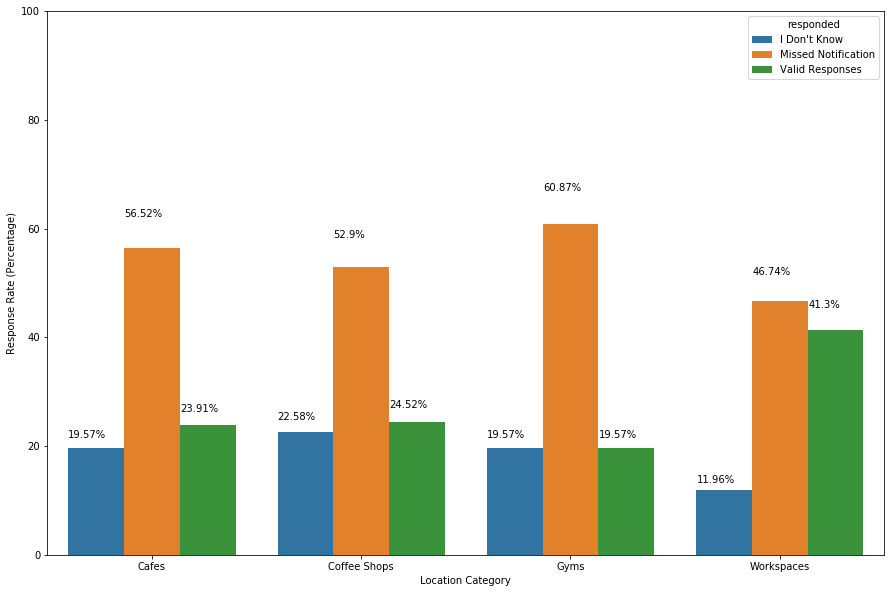

In [47]:
fig, ax = plt.subplots(figsize=(15, 10));
location_response_bar = sns.barplot(data=location_response_bar_data, x='tag', y='count', hue='responded')
location_response_bar.set(xlabel='Location Category', ylabel='Response Rate (Percentage)')
location_response_bar.set_ylim(0, 100)
for p in location_response_bar.patches:
    location_response_bar.annotate('{}%'.format(p.get_height()), (p.get_x() * 1.001, p.get_height() * 1.1))

#### Over Non-missed Notifications

In [148]:
non_missed_valid_bytag = valid_bytag.merge(non_missed_bytag, on='tag', how='outer')
non_missed_valid_bytag.fillna(0, inplace=True)
non_missed_valid_bytag.rename(columns={'count_x': 'count', 'count_y': 'total'}, inplace=True)
non_missed_valid_bytag['proportion'] = round(100 * non_missed_valid_bytag['count'] / non_missed_valid_bytag['total'], 2)

non_missed_idk_bytag = idk_bytag.merge(non_missed_bytag, on='tag', how='outer')
non_missed_idk_bytag.fillna(0, inplace=True)
non_missed_idk_bytag.rename(columns={'count_x': 'count', 'count_y': 'total'}, inplace=True)
non_missed_idk_bytag['proportion'] = round(100 * non_missed_idk_bytag['count'] / non_missed_idk_bytag['total'], 2)

In [149]:
print('Valid Responses by Category (Non-Missed Notification): \n{}\n'.format(non_missed_valid_bytag))
print('IDK Responses by Category (Non-Missed Notification): \n{}\n'.format(non_missed_idk_bytag))

Valid Responses by Category (Non-Missed Notification): 
           tag  count  total  proportion
0        cafes     22     40       55.00
1  coffeeshops     38     73       52.05
2         food      1      1      100.00
3         gyms      9     18       50.00
4   workspaces     38     49       77.55

IDK Responses by Category (Non-Missed Notification): 
           tag  count  total  proportion
0        cafes   18.0     40       45.00
1  coffeeshops   35.0     73       47.95
2         gyms    9.0     18       50.00
3   workspaces   11.0     49       22.45
4         food    0.0      1        0.00



### Response rate by location (over total notifications)

In [150]:
total_byloc = pd.DataFrame({'count': merged_notifications.groupby('locationCommonName')['objectId'].count()}).reset_index()
valid_byloc = pd.DataFrame({'count': valid_notifications.groupby('locationCommonName')['objectId'].count()}).reset_index()
idk_byloc = pd.DataFrame({'count': idk_notifications.groupby('locationCommonName')['objectId'].count()}).reset_index()
non_missed_byloc = pd.DataFrame({'count': non_missed_notifications.groupby('locationCommonName')['objectId'].count()}).reset_index()
missed_byloc = pd.DataFrame({'count': missed_notifications.groupby('locationCommonName')['objectId'].count()}).reset_index()

#### Over Total Notifications

In [151]:
total_valid_byloc = valid_byloc.merge(total_byloc, on='locationCommonName', how='outer')
total_valid_byloc.fillna(0, inplace=True)
total_valid_byloc.rename(columns={'count_x': 'count', 'count_y': 'total'}, inplace=True)
total_valid_byloc['proportion'] = round(100 * total_valid_byloc['count'] / total_valid_byloc['total'], 2)

total_idk_byloc = idk_byloc.merge(total_byloc, on='locationCommonName', how='outer')
total_idk_byloc.fillna(0, inplace=True)
total_idk_byloc.rename(columns={'count_x': 'count', 'count_y': 'total'}, inplace=True)
total_idk_byloc['proportion'] = round(100 * total_idk_byloc['count'] / total_idk_byloc['total'], 2)

total_missed_byloc = missed_byloc.merge(total_byloc, on='locationCommonName', how='outer')
total_missed_byloc.fillna(0, inplace=True)
total_missed_byloc.rename(columns={'count_x': 'count', 'count_y': 'total'}, inplace=True)
total_missed_byloc['proportion'] = round(100 * total_missed_byloc['count'] / total_missed_byloc['total'], 2)

In [152]:
print('Valid Responses by Location: \n{}\n'.format(total_valid_byloc))
print('IDK Responses by Location: \n{}\n'.format(total_idk_byloc))
print('Missed Notifications by Location: \n{}\n'.format(total_missed_byloc))

Valid Responses by Location: 
             locationCommonName  count  total  proportion
0                                  1.0      1      100.00
1                     Blomquist    5.0     25       20.00
2        Brew Bike in Annenberg    7.0      7      100.00
3                    Coffee Lab   20.0     59       33.90
4         Delta Lab/Hackerspace   13.0     22       59.09
5   Food for Thought at Garrett    7.0     56       12.50
6        Kregse Hall Entry Area   24.0     68       35.29
7                    Lisas Cafe    7.0     24       29.17
8             Main Library Core    1.0      2       50.00
9                      Norbucks    1.0     10       10.00
10                Norris Dunkin    4.0      6       66.67
11                 Peets Coffee    4.0     25       16.00
12                         SPAC    4.0     13       30.77
13             Starbucks Coffee    9.0     55       16.36
14                 Tech Express    1.0      5       20.00
15                       Patten    0.0    

#### Over Non-Missed Notifications

In [153]:
non_missed_valid_byloc = valid_byloc.merge(non_missed_byloc, on='locationCommonName', how='outer')
non_missed_valid_byloc.fillna(0, inplace=True)
non_missed_valid_byloc.rename(columns={'count_x': 'count', 'count_y': 'total'}, inplace=True)
non_missed_valid_byloc['proportion'] = round(100 * non_missed_valid_byloc['count'] / non_missed_valid_byloc['total'], 2)

non_missed_idk_byloc = idk_byloc.merge(non_missed_byloc, on='locationCommonName', how='outer')
non_missed_idk_byloc.fillna(0, inplace=True)
non_missed_idk_byloc.rename(columns={'count_x': 'count', 'count_y': 'total'}, inplace=True)
non_missed_idk_byloc['proportion'] = round(100 * non_missed_idk_byloc['count'] / non_missed_idk_byloc['total'], 2)

In [154]:
print('Valid Responses by Location: \n{}\n'.format(non_missed_valid_byloc))
print('IDK Responses by Location: \n{}\n'.format(non_missed_idk_byloc))

Valid Responses by Location: 
             locationCommonName  count  total  proportion
0                                  1.0      1      100.00
1                     Blomquist    5.0     10       50.00
2        Brew Bike in Annenberg    7.0      7      100.00
3                    Coffee Lab   20.0     38       52.63
4         Delta Lab/Hackerspace   13.0     13      100.00
5   Food for Thought at Garrett    7.0     23       30.43
6        Kregse Hall Entry Area   24.0     35       68.57
7                    Lisas Cafe    7.0      9       77.78
8             Main Library Core    1.0      1      100.00
9                      Norbucks    1.0      1      100.00
10                Norris Dunkin    4.0      4      100.00
11                 Peets Coffee    4.0      7       57.14
12                         SPAC    4.0      7       57.14
13             Starbucks Coffee    9.0     23       39.13
14                 Tech Express    1.0      1      100.00
15                       Patten    0.0    

## Analyze how much data has scaffolded for each location

In [155]:
# In general
number_scaffolded_responses = pd.DataFrame({'count': valid_notifications.groupby('hotspotId')['objectId'].count()}).reset_index()
print('Number Unique Hotspots: {}\n'.format(len(number_scaffolded_responses)))
print('Descriptive Statistics of Scaffolded Responses: \n {}'.format(number_scaffolded_responses.describe(percentiles=np.arange(0, 1, 0.05))))

Number Unique Hotspots: 81

Descriptive Statistics of Scaffolded Responses: 
            count
count  81.000000
mean    1.333333
std     0.651920
min     1.000000
0%      1.000000
5%      1.000000
10%     1.000000
15.0%   1.000000
20%     1.000000
25%     1.000000
30.0%   1.000000
35%     1.000000
40%     1.000000
45%     1.000000
50%     1.000000
55.0%   1.000000
60.0%   1.000000
65%     1.000000
70%     1.000000
75%     2.000000
80%     2.000000
85.0%   2.000000
90%     2.000000
95%     2.000000
max     4.000000


## Time between receiving notification and responding

In [156]:
non_missed_notifications = merged_notifications[~merged_notifications['response'].isin(['missed notification'])].reset_index(drop=True)
non_missed_notifications['time_between'] = non_missed_notifications['timestamp_response'] - non_missed_notifications['timestamp_sent']

In [157]:
non_missed_notifications.head()

,createdAt,gmtOffset,hotspotId,notificationString,objectId,timestamp_sent,updatedAt,vendorId,timestamp_response,question,response,tag,locationCommonName,time_between
0,1494354230,-18000,8tyanI2cDs,Notified for beacon region RsX6mIV5p0,SSoq7oOSLR,1494354229,1494354230,082918FC-40D0-4E15-916F-B0DC4DCE8A7A,1494354371,linelength,short: < 5 people,cafes,Brew Bike in Annenberg,142
1,1494361244,-18000,GKyoBvb2VT,"Notified for GKyoBvb2VT (42.055781, -87.674974...",AHYoCdA20I,1494361224,1494361244,082918FC-40D0-4E15-916F-B0DC4DCE8A7A,1494361230,linelength,I don't know,cafes,Food for Thought at Garrett,6
2,1494363736,-18000,5t5BetXvyS,"Notified for 5t5BetXvyS (42.054274, -87.678216...",ZOTQOrZKjI,1494363736,1494363736,F2F4A0A8-98C7-474C-91DF-B6CA1A22B59B,1494363747,cardio,I don't know,gyms,Blomquist,11
3,1494366652,-18000,HBzYGSKU51,Notified for beacon region CYtXsryXtJ,OIzxRFqmjH,1494366652,1494366652,082918FC-40D0-4E15-916F-B0DC4DCE8A7A,1494366656,tablesavailable,yes,workspaces,Delta Lab/Hackerspace,4
4,1494368915,-18000,HBzYGSKU51,Notified for beacon region CYtXsryXtJ,QlEPDg9Fvb,1494368914,1494368915,F2F4A0A8-98C7-474C-91DF-B6CA1A22B59B,1494368997,tabletype,communal tables,workspaces,Delta Lab/Hackerspace,83


### Summary stats for time between (all response types, in seconds)

In [158]:
non_missed_notifications['time_between'].describe(percentiles=np.arange(0, 1, 0.05))

count      181.000000
mean       733.364641
std       2196.093645
min          3.000000
0%           3.000000
5%           5.000000
10%          6.000000
15.0%        8.000000
20%         11.000000
25%         15.000000
30.0%       22.000000
35%         28.000000
40%         41.000000
45%         53.000000
50%         68.000000
55.0%       95.000000
60.0%      151.000000
65%        190.000000
70%        273.000000
75%        330.000000
80%        429.000000
85.0%      714.000000
90%       1723.000000
95%       3993.000000
max      16662.000000
Name: time_between, dtype: float64

### Summary stats for time between (not including idk responses, in seconds)

In [159]:
non_idk_timebetween = non_missed_notifications[~non_missed_notifications['response'].isin(['I don\'t know'])]['time_between']
non_idk_timebetween.describe(percentiles=np.arange(0, 1, 0.05))

count      108.000000
mean       569.870370
std       1668.834632
min          3.000000
0%           3.000000
5%           5.000000
10%          7.700000
15.0%       11.000000
20%         12.800000
25%         18.000000
30.0%       24.000000
35%         27.450000
40%         38.400000
45%         47.450000
50%         60.000000
55.0%       73.550000
60.0%       98.800000
65%        150.650000
70%        195.400000
75%        286.250000
80%        372.400000
85.0%      579.500000
90%       1357.800000
95%       3567.750000
max      13585.000000
Name: time_between, dtype: float64

### Summary stats for time between (only idk responses, in seconds)

In [160]:
idk_timebetween = non_missed_notifications[non_missed_notifications['response'].isin(['I don\'t know'])]['time_between']
idk_timebetween.describe(percentiles=np.arange(0, 1, 0.05))

count       73.000000
mean       975.246575
std       2796.215363
min          4.000000
0%           4.000000
5%           5.600000
10%          6.000000
15.0%        6.000000
20%          7.400000
25%         11.000000
30.0%       15.400000
35%         28.600000
40%         46.600000
45%         61.000000
50%        140.000000
55.0%      163.800000
60.0%      202.600000
65%        276.800000
70%        296.800000
75%        341.000000
80%        540.400000
85.0%      970.800000
90%       2300.000000
95%       4359.800000
max      16662.000000
Name: time_between, dtype: float64

### Summary stats parsed out by location category (all responses, in seconds)

In [161]:
non_missed_notifications.groupby('tag')['time_between'].describe(percentiles=np.arange(0, 1, 0.05)).transpose()

tag,cafes,coffeeshops,food,gyms,workspaces
count,40.000000,73.000000,1.0,18.000000,49.000000
mean,159.850000,1198.150685,429.0,288.722222,678.653061
std,394.507453,3135.014295,NaN,655.578936,1543.598522
min,3.000000,5.000000,429.0,5.000000,4.000000
0%,3.000000,5.000000,429.0,5.000000,4.000000
5%,4.950000,7.600000,429.0,5.850000,4.400000
10%,5.000000,9.200000,429.0,6.000000,6.000000
15.0%,6.000000,16.800000,429.0,6.000000,11.000000
20%,6.800000,22.800000,429.0,6.400000,11.600000
25%,7.750000,26.000000,429.0,7.250000,14.000000


### Summary stats parsed out by location category (not including idk responses, in seconds)

In [162]:
non_missed_notifications[~non_missed_notifications['response'].isin(['I don\'t know'])].groupby('tag')['time_between'].describe(percentiles=np.arange(0, 1, 0.05)).transpose()

tag,cafes,coffeeshops,food,gyms,workspaces
count,22.000000,38.000000,1.0,9.000000,38.000000
mean,199.909091,663.289474,429.0,480.222222,715.578947
std,512.121908,2269.616159,NaN,888.267102,1571.207070
min,3.000000,5.000000,429.0,7.000000,4.000000
0%,3.000000,5.000000,429.0,7.000000,4.000000
5%,5.000000,7.850000,429.0,7.400000,4.850000
10%,5.100000,8.700000,429.0,7.800000,9.800000
15.0%,6.750000,20.200000,429.0,8.800000,11.000000
20%,11.800000,22.800000,429.0,10.400000,12.000000
25%,15.750000,24.000000,429.0,12.000000,14.250000


### Summary stats parsed out by location category (only idk responses, in seconds)

In [163]:
non_missed_notifications[non_missed_notifications['response'].isin(['I don\'t know'])].groupby('tag')['time_between'].describe(percentiles=np.arange(0, 1, 0.05)).transpose()

tag,cafes,coffeeshops,gyms,workspaces
count,18.000000,35.000000,9.000000,11.000000
mean,110.888889,1778.857143,97.222222,551.090909
std,168.681701,3813.182314,204.351277,1509.868501
min,4.000000,6.000000,5.000000,4.000000
0%,4.000000,6.000000,5.000000,4.000000
5%,4.850000,7.700000,5.400000,5.000000
10%,5.700000,10.400000,5.800000,6.000000
15.0%,6.000000,12.800000,6.000000,6.000000
20%,6.400000,36.800000,6.000000,6.000000
25%,7.000000,96.000000,6.000000,15.500000


## Contributions by Time of Day